In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

plt.rcParams['ytick.left']=False
plt.rcParams['xtick.bottom']=False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.labelbottom']=False
plt.rcParams['ytick.labelleft']=False


im = imageio.imread('img/cover.png')[:,:,0]


def get_sparse(X,missing,repl = np.nan):
    """
    Input:
    X [array] data matrix
    missing [float] percentage of missing entries
    repl [float] value assigned to missing entries
    
    Returns:
    X_incomplete [array] data matrix with missing entries set to repl
    missing_mask [array] boolean mask marking missing entries
    """
    
    size = np.size(X)
    missing_mask = np.array(size*[False])
    missing_mask[:int(missing*size)] = True
    np.random.shuffle(missing_mask)
    missing_mask = missing_mask.reshape(np.shape(X))
    
    X_incomplete = np.array(X,dtype=float)
    X_incomplete[missing_mask] = np.nan
    
    return X_incomplete, missing_mask



Using TensorFlow backend.


KNN Imputation
Imputing row 1/326 with 154 missing, elapsed time: 0.225
Imputing row 101/326 with 163 missing, elapsed time: 0.454
Imputing row 201/326 with 145 missing, elapsed time: 0.709
Imputing row 301/326 with 143 missing, elapsed time: 0.969
Nuclear Norm Minimization
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 595181
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 297869, constraints m = 496077
Cones:	linear vars: 297312
	sd vars: 198765, sd blks: 1
Setup time: 3.37e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
------------------------------------------

[SoftImpute] Iter 50: observed MAE=0.074276 rank=175
[SoftImpute] Iter 51: observed MAE=0.074263 rank=175
[SoftImpute] Iter 52: observed MAE=0.074251 rank=174
[SoftImpute] Iter 53: observed MAE=0.074237 rank=174
[SoftImpute] Iter 54: observed MAE=0.074226 rank=174
[SoftImpute] Iter 55: observed MAE=0.074216 rank=174
[SoftImpute] Iter 56: observed MAE=0.074206 rank=174
[SoftImpute] Iter 57: observed MAE=0.074196 rank=173
[SoftImpute] Iter 58: observed MAE=0.074186 rank=173
[SoftImpute] Iter 59: observed MAE=0.074178 rank=173
[SoftImpute] Iter 60: observed MAE=0.074170 rank=173
[SoftImpute] Iter 61: observed MAE=0.074162 rank=173
[SoftImpute] Iter 62: observed MAE=0.074155 rank=172
[SoftImpute] Iter 63: observed MAE=0.074145 rank=172
[SoftImpute] Iter 64: observed MAE=0.074137 rank=172
[SoftImpute] Iter 65: observed MAE=0.074130 rank=172
[SoftImpute] Iter 66: observed MAE=0.074123 rank=172
[SoftImpute] Iter 67: observed MAE=0.074115 rank=171
[SoftImpute] Iter 68: observed MAE=0.074107 ra

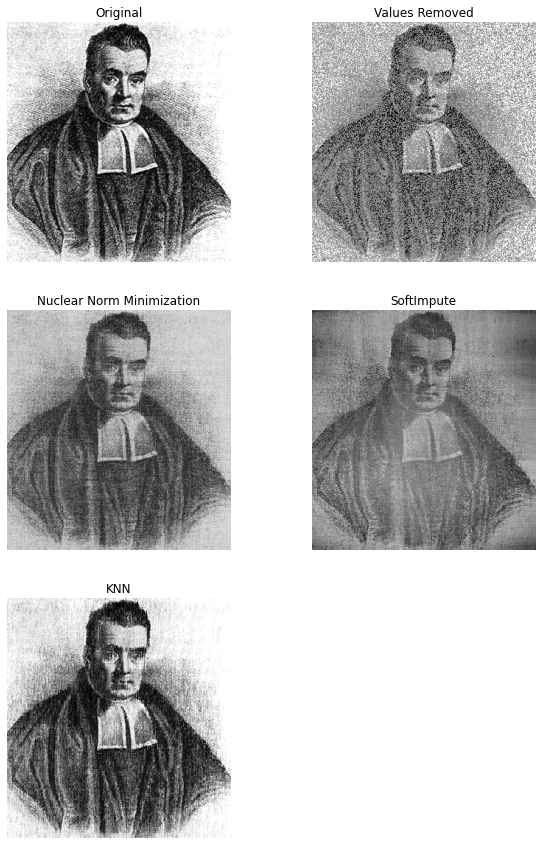

In [2]:
# Code curtesy of https://pypi.org/project/fancyimpute/

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from time import time

X = (im-np.mean(im))/np.std(im)

X_incomplete, missing_mask = get_sparse(X,missing=0.5)
T = {}

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
print("KNN Imputation")
t0 = time()
X_filled_knn = KNN(k=3).fit_transform(X_incomplete)
T['knn'] = time()-t0

# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
print("Nuclear Norm Minimization")
t0 = time()
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)
T['nnm'] = time()-t0

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
print("Soft Impute")
t0 = time()
X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)
T['softImpute'] = time()-t0




# print mean squared error for the  imputation methods above
nnm_mse = ((X_filled_nnm[missing_mask] - X[missing_mask]) ** 2).mean()
print("Nuclear norm minimization MSE: %f" % nnm_mse)

softImpute_mse = ((X_filled_softimpute[missing_mask] - X[missing_mask]) ** 2).mean()
print("SoftImpute MSE: %f" % softImpute_mse)

knn_mse = ((X_filled_knn[missing_mask] - X[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)

print(T)


fig, ax = plt.subplots(3,2,figsize=(10,15))

X_noisy = X_incomplete
X_incomplete[missing_mask] = 0


for a,x,title in zip(ax.flatten(),
                     [X,X_noisy,X_filled_nnm,X_filled_softimpute,X_filled_knn],
                     'Original,Values Removed,Nuclear Norm Minimization,SoftImpute,KNN'.split(',')):
    a.imshow(x,'gray')
    a.set_title(title)
    

plt.savefig('img/impute_05.png',bbox_inches='tight')

KNN Imputation
Imputing row 1/326 with 235 missing, elapsed time: 0.249
Imputing row 101/326 with 240 missing, elapsed time: 0.631
Imputing row 201/326 with 248 missing, elapsed time: 1.101
Imputing row 301/326 with 245 missing, elapsed time: 1.662
Nuclear Norm Minimization
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 535719
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 297869, constraints m = 496077
Cones:	linear vars: 297312
	sd vars: 198765, sd blks: 1
Setup time: 3.38e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
------------------------------------------

[SoftImpute] Iter 47: observed MAE=0.045915 rank=150
[SoftImpute] Iter 48: observed MAE=0.045841 rank=149
[SoftImpute] Iter 49: observed MAE=0.045785 rank=148
[SoftImpute] Iter 50: observed MAE=0.045722 rank=147
[SoftImpute] Iter 51: observed MAE=0.045678 rank=147
[SoftImpute] Iter 52: observed MAE=0.045634 rank=145
[SoftImpute] Iter 53: observed MAE=0.045544 rank=144
[SoftImpute] Iter 54: observed MAE=0.045481 rank=143
[SoftImpute] Iter 55: observed MAE=0.045443 rank=143
[SoftImpute] Iter 56: observed MAE=0.045392 rank=142
[SoftImpute] Iter 57: observed MAE=0.045365 rank=142
[SoftImpute] Iter 58: observed MAE=0.045322 rank=140
[SoftImpute] Iter 59: observed MAE=0.045267 rank=139
[SoftImpute] Iter 60: observed MAE=0.045218 rank=139
[SoftImpute] Iter 61: observed MAE=0.045186 rank=138
[SoftImpute] Iter 62: observed MAE=0.045146 rank=138
[SoftImpute] Iter 63: observed MAE=0.045110 rank=137
[SoftImpute] Iter 64: observed MAE=0.045076 rank=137
[SoftImpute] Iter 65: observed MAE=0.045055 ra

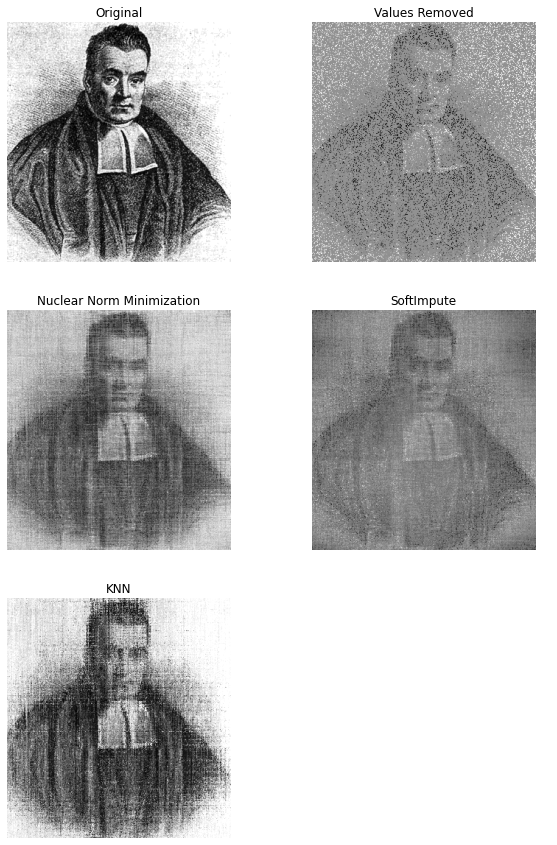

In [3]:
# Code curtesy of https://pypi.org/project/fancyimpute/

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from time import time

X = (im-np.mean(im))/np.std(im)

X_incomplete, missing_mask = get_sparse(X,missing=0.8)
T = {}

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
print("KNN Imputation")
t0 = time()
X_filled_knn = KNN(k=3).fit_transform(X_incomplete)
T['knn'] = time()-t0

# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
print("Nuclear Norm Minimization")
t0 = time()
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)
T['nnm'] = time()-t0

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
print("Soft Impute")
t0 = time()
X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)
T['softImpute'] = time()-t0




# print mean squared error for the  imputation methods above
nnm_mse = ((X_filled_nnm[missing_mask] - X[missing_mask]) ** 2).mean()
print("Nuclear norm minimization MSE: %f" % nnm_mse)

softImpute_mse = ((X_filled_softimpute[missing_mask] - X[missing_mask]) ** 2).mean()
print("SoftImpute MSE: %f" % softImpute_mse)

knn_mse = ((X_filled_knn[missing_mask] - X[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)

print(T)


fig, ax = plt.subplots(3,2,figsize=(10,15))

X_noisy = X_incomplete
X_incomplete[missing_mask] = 0


for a,x,title in zip(ax.flatten(),
                     [X,X_noisy,X_filled_nnm,X_filled_softimpute,X_filled_knn],
                     'Original,Values Removed,Nuclear Norm Minimization,SoftImpute,KNN'.split(',')):
    a.imshow(x,'gray')
    a.set_title(title)

    plt.savefig('img/impute_08.png',bbox_inches='tight')